# Testing iterative methods

In [16]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from modules_no_st import coh_ang_calc
from skimage.transform import rescale
from skimage import color

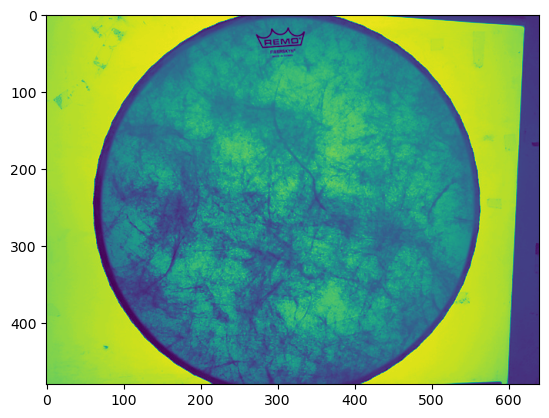

In [18]:
drumhead = cv.imread("drumhead.jpg")
drum_gray = color.rgb2gray(drumhead)
plt.imshow(drum_gray)

In [19]:
# coh, ang = coh_ang_calc(drum_gray)
# plt.imshow(coh)

In [20]:
# plt.imshow(ang)

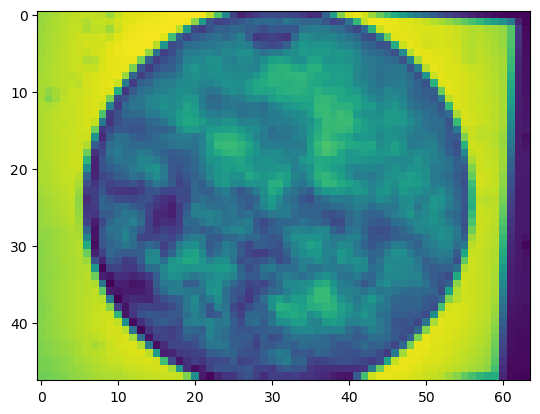

In [21]:
drum_small = rescale(drum_gray, 0.1)
plt.imshow(drum_small)

In [11]:
# iteratively apply diffusion steps - maybe add time_step, analagous to sigma of filter?
def diffuse(img, ksize, diffusion_step, num_steps):
    assert ksize>=1 and ksize%2==1, "kernel must be >= 1 and odd"
    assert num_steps >=0, "must have nonnegative number of steps - no reverse diffusion yet :)"
    if num_steps == 0:
        return img # img without filtering is just img
    
    # shouldn't be bottleneck (i hope)
    for _ in range(num_steps):
        img = diffusion_step(img, ksize)
    return img

def border(img, border_width):
    return cv.copyMakeBorder(img, border_width, border_width, border_width, border_width, cv.BORDER_WRAP)

# kernel diameter of 3, average pixels
# responsible for bordering img before convolution-adjacent operation
def linear_diffusion_step(img, ksize):
    k_radius = ksize//2
    new_img = np.zeros_like(img, dtype=float)
    # print(new_img.shape)
    img_padded = border(img, k_radius)
    h, w = new_img.shape
    for r in range(h):
        for c in range(w):
            # normalization = 1/(ksize * ksize)
            normalization = 1
            avg = np.mean(img_padded[r:r+2*k_radius+1, c:c+2*k_radius+1])
            new_img[r, c] = normalization*avg
    return new_img

# Idea: instead of using 2d for loop, create ndarry of shape(img.shape[0], img.shape[1], ksize, ksize)
# Then, perform almost-convolution with filter[r, c, x, y] *= img[r-ksize//2+x]
# check out numpy vectorize and sliding-window
def linear_diffusion_step_smarter(img, ksize):
    filter = np.ones(img.shape + (ksize, ksize))
    # print(filter.shape)
    # filter[r, c, :, :] = elliptical gaussian based on structure tensor
    # filter[r, c, x, y] *= img[r-ksize//2+x, c-ksize//2+y]
    pass

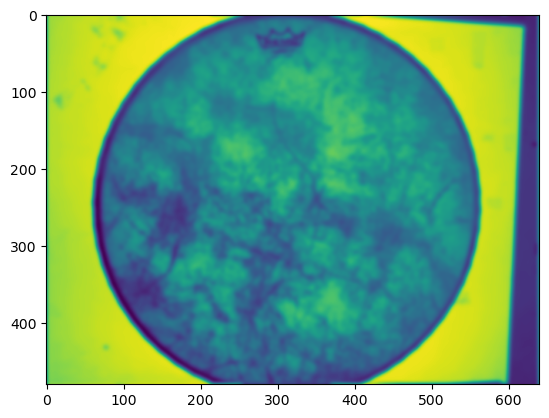

In [13]:
blur_drumhead = diffuse(drum_gray, 3, linear_diffusion_step, 10)
plt.imshow(blur_drumhead)

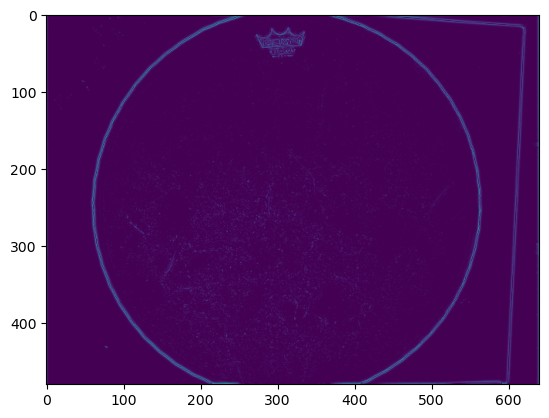

In [14]:
diff = blur_drumhead - drum_gray
diff /= diff.mean()
diff *= diff
plt.imshow(diff)

In [15]:
height, width = drum_small.shape
r_bounds = height+1
c_bounds = width+1

max_r = max(range(r_bounds))
max_c = max(range(c_bounds))
for r in range(r_bounds):
    for c in range(c_bounds):
        if (r == 0 or r == max_r) and (c == 0 or c == max_c):
            print(f'({r}, {c})')

(0, 0)
(0, 64)
(48, 0)
(48, 64)
